In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime, timedelta
from fredapi import Fred
import quandl

In [3]:
def get_info(names):
    data = []
    for i in range(len(names)):
        data.append(fred.get_series(names[i]).to_frame().rename(columns={0:names[i]}))
        data[i] = data[i].groupby(data[i].index.year).mean().dropna()
    return data

In [4]:
# https://github.com/mortada/fredapi
fred = Fred(api_key="a02df0a22c57860f5f7cf25edc70ffb3")
quandl.ApiConfig.api_key = "QZLZXdHDDPZna9Yw48NP"

# South - South Carolina

Define the variables to be used in analysis:

X attributes:
 - *Monthly* Stocks
    - S&P 500 (MULTPL/SP500_REAL_PRICE_MONTH)
 - *Quarterly* Gross Domestic Product (GDP)
 - *Annual* Unemployment Rate (LAUST450000000000003A)
 - *Annual* House Ownership Ratio (SCHOWN)
 - *Annual* Resident Population (SCPOP)
 - *Annual* Median Income Rate (MEHOINUSSCA672N)
 - *Annual* Home Vacancy Rate (SCHVAC)

y attributes:

 - *Quarterly* Ohio State Housing Price Index (SCSTHPI)

Connect to APIs and create a dataframe with information from each dataset:

In [5]:
sp500 = quandl.get('MULTPL/SP500_REAL_PRICE_MONTH').rename(columns={'Value':'SP500'})
names_sc = ['LAUST450000000000003A', "SCHOWN","SCPOP", "MEHOINUSSCA672N", "SCHVAC", "GDP"]
sp500 = sp500.groupby(sp500.index.year).mean().dropna()
sc_data_series = get_info(names_sc)  + [sp500]

In [6]:
# quarterly housing price index
scHPI = fred.get_series('SCSTHPI').to_frame()
scHPI.index.name = "DATE"
scHPI = scHPI.rename(columns={0:"SCSTHPI"})
# convert to annual
scHPI_annual = scHPI.groupby(scHPI.index.year).mean()

In [7]:
sc_annual = scHPI_annual.copy()
for df in sc_data_series:
    sc_annual = sc_annual.merge(df, left_index=True, right_index=True)
sc_annual.tail()

,SCSTHPI,LAUST450000000000003A,SCHOWN,SCPOP,MEHOINUSSCA672N,SCHVAC,GDP,SP500
2014,309.3825,6.5,72.9,4823.793,47702.0,2.7,17527.25825,1930.667500
2015,325.5225,6.0,67.1,4892.253,49137.0,2.1,18224.78025,2061.199167
2016,343.3150,5.0,68.9,4958.235,56858.0,1.9,18715.04050,2091.844167
2017,363.0900,4.3,72.8,5021.219,55866.0,1.9,19519.42350,2448.217500
2018,388.1250,3.4,72.0,5084.127,57444.0,1.9,20580.22300,2744.680000


Analyze the correlation coefficient for each indicator we have specified:

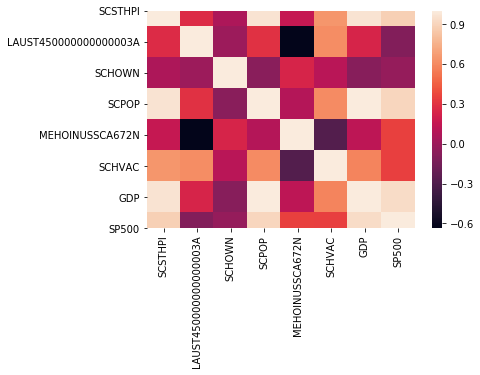

In [8]:
corr = sc_annual.corr().round(4)
sns.heatmap(data=corr)

In [9]:
corr

,SCSTHPI,LAUST450000000000003A,SCHOWN,SCPOP,MEHOINUSSCA672N,SCHVAC,GDP,SP500
SCSTHPI,1.0000,0.2672,0.0640,0.9651,0.1580,0.6438,0.9666,0.8790
LAUST450000000000003A,0.2672,1.0000,0.0004,0.2936,-0.6345,0.6129,0.2355,-0.0920
SCHOWN,0.0640,0.0004,1.0000,-0.0665,0.2389,0.1073,-0.0766,-0.0276
SCPOP,0.9651,0.2936,-0.0665,1.0000,0.0893,0.6105,0.9972,0.9105
MEHOINUSSCA672N,0.1580,-0.6345,0.2389,0.0893,1.0000,-0.2826,0.1275,0.3533
SCHVAC,0.6438,0.6129,0.1073,0.6105,-0.2826,1.0000,0.5840,0.3471
GDP,0.9666,0.2355,-0.0766,0.9972,0.1275,0.5840,1.0000,0.9316
SP500,0.8790,-0.0920,-0.0276,0.9105,0.3533,0.3471,0.9316,1.0000


Create a model using linear regression to express the Housing Price Index as dependent on the other datasets we have downloaded:

In [10]:
X = sc_annual.drop(columns=['SCSTHPI'], axis=1)
Y = sc_annual['SCSTHPI']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('Root Mean Squared Error is {}'.format(rmse))
print('R-Squared score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('Root Mean Squared Error is {}'.format(rmse))
print('R-Squared score is {}'.format(r2))

The model performance for training set
--------------------------------------
Root Mean Squared Error is 13.04729263105491
R-Squared score is 0.9701514692551751


The model performance for testing set
--------------------------------------
Root Mean Squared Error is 14.387754373625608
R-Squared score is 0.9519664612277512
